<a href="https://colab.research.google.com/github/jaidatta71/ML---Berkeley/blob/main/10.2%20Time%20Series%20Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [5]:
#Load the dataset
homeSales = pd.read_csv('/content/drive/MyDrive/colab_activity10_2_solution/data/raw_sales.csv')
homeSales

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3
...,...,...,...,...,...
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2


In [6]:
print(type(homeSales.datesold))

<class 'pandas.core.series.Series'>


In [7]:
homeSales['datesold'] = pd.to_datetime(homeSales.datesold)
homeSales.set_index('datesold', inplace=True)

In [8]:
homeSales.head()
homeSales.propertyType.value_counts()
drop_col = ['postcode','propertyType']
homeSales.drop(drop_col, axis=1, inplace=True)
homeSales.head()

,price,bedrooms
datesold,,
2007-02-07,525000,4
2007-02-27,290000,3
2007-03-07,328000,3
2007-03-09,380000,4
2007-03-21,310000,3


In [9]:
# Time series analysis for 2 Bed rooms
homeSales.bedrooms.value_counts()
bd3 = homeSales[homeSales['bedrooms']==2].sort_index()
bd3.drop('bedrooms', axis=1, inplace=True)
bd3

,price
datesold,
2007-06-27,300000
2007-07-05,300000
2007-07-20,360000
2007-08-28,325000
2007-08-30,315000
...,...
2019-07-25,475000
2019-07-25,560000
2019-07-26,589000


In [10]:
# convert datesold to monthly, so that we get periodic data
# The data contains multiple rows with the same dates (each sale is recorded, and there could be multiple sales per day and definitely per month).
#bd3['2015-11-01':'2015-12-01'].resample("ME").mean().sort_index()
bd3_monthly = bd3.resample("ME").mean().sort_index()
bd3_monthly = bd3_monthly.dropna(subset=["price"])
#bd3_monthly['2015-11-01':'2015-12-01']
bd3_monthly


,price
datesold,
2007-06-30,300000.000000
2007-07-31,330000.000000
2007-08-31,320000.000000
2007-09-30,401800.000000
2007-10-31,405000.000000
...,...
2019-03-31,398793.750000
2019-04-30,431436.309524
2019-05-31,489565.517241


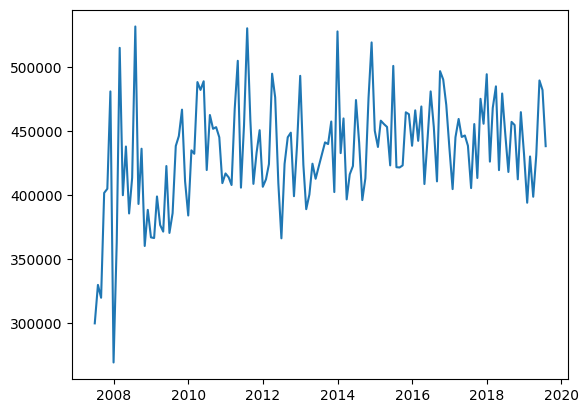

In [11]:
plt.plot(bd3_monthly)

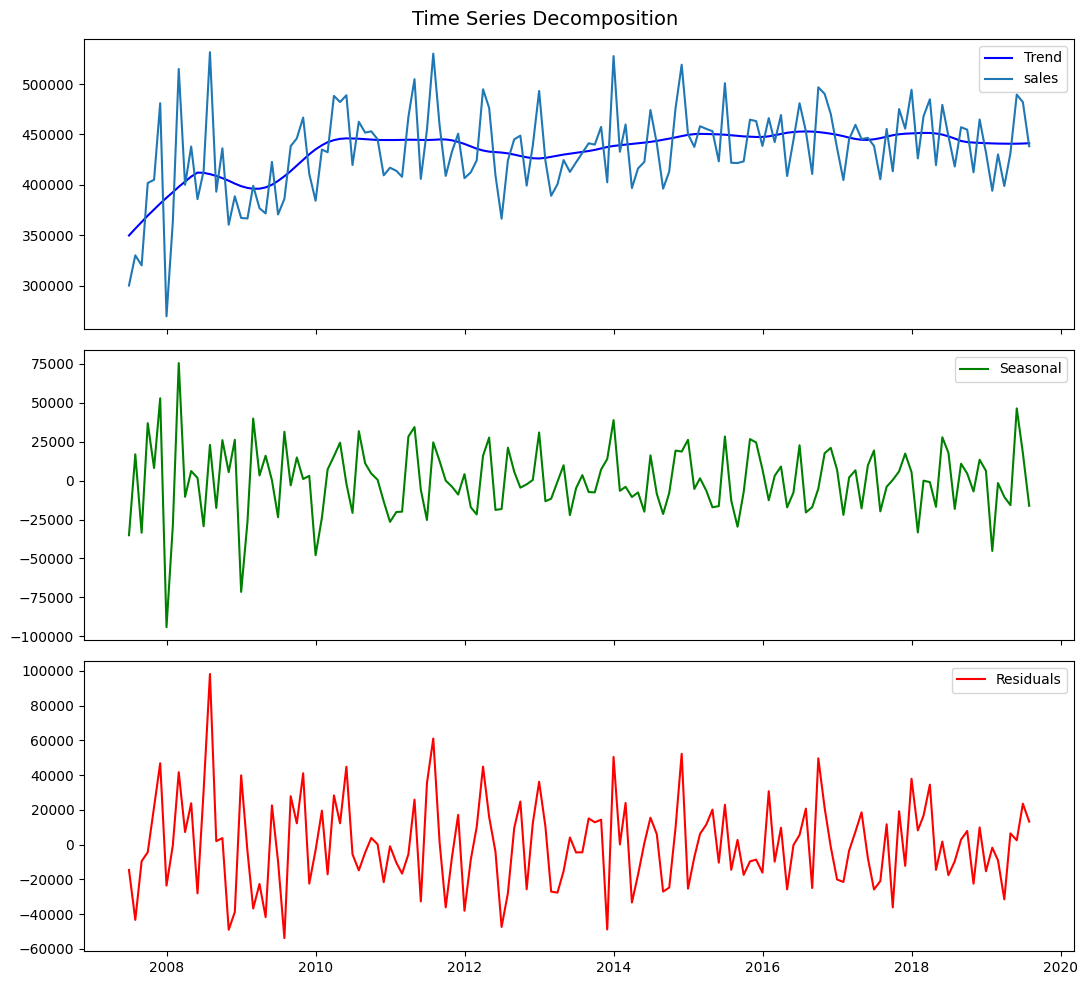

In [13]:
stl     = sm.tsa.STL(bd3_monthly, 12)
results = stl.fit()                      #  .fit() Runs the decomposition and gives you access to the components.

trend    = results.trend
seasonal = results.seasonal
resid    = results.resid



fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

# Plot each component
axes[0].plot(trend, label="Trend", color="blue")
axes[0].plot(bd3_monthly, label ='sales')
axes[0].legend(loc="best")

axes[1].plot(seasonal, label="Seasonal", color="green")
axes[1].legend(loc="best")

axes[2].plot(resid, label="Residuals", color="red")
axes[2].legend(loc="best")

# Add a shared title
fig.suptitle("Time Series Decomposition", fontsize=14)

plt.tight_layout()
plt.show()


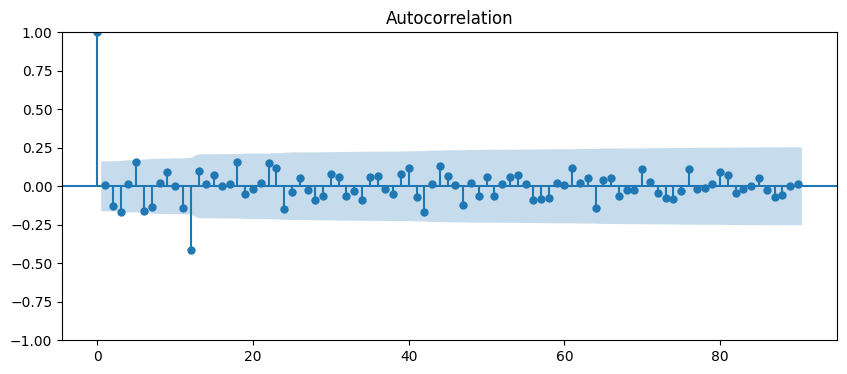

In [14]:
#  Residual is not stationary
import statsmodels.graphics.tsaplots as tsaplots
fig, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(resid,lags=90, ax=ax)
plt.show()

In [15]:
y_hist = bd3_monthly[:'2015-12-01']
y_future = bd3_monthly['2016-01-01':]

In [16]:
print(y_hist.shape)
print(y_future.shape)
print(y_hist.tail())
print(y_future.head())
print(type(y_hist))

(102, 1)
(43, 1)
                    price
datesold                 
2015-07-31  421856.242424
2015-08-31  421630.769231
2015-09-30  423274.193548
2015-10-31  464688.679245
2015-11-30  463242.424242
                    price
datesold                 
2016-01-31  466214.285714
2016-02-29  442432.000000
2016-03-31  469246.666667
2016-04-30  408721.621622
2016-05-31  444380.952381
<class 'pandas.core.frame.DataFrame'>


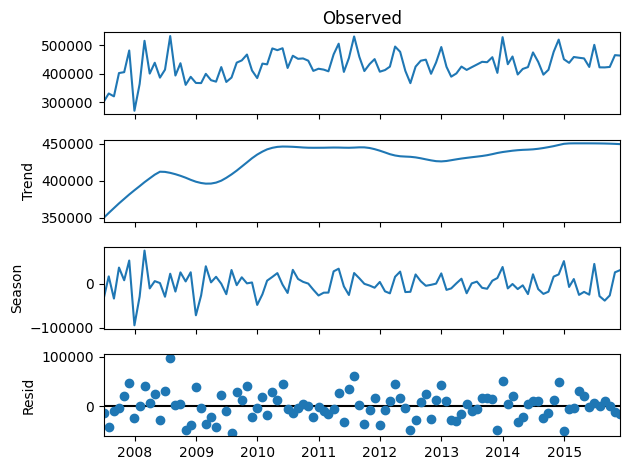

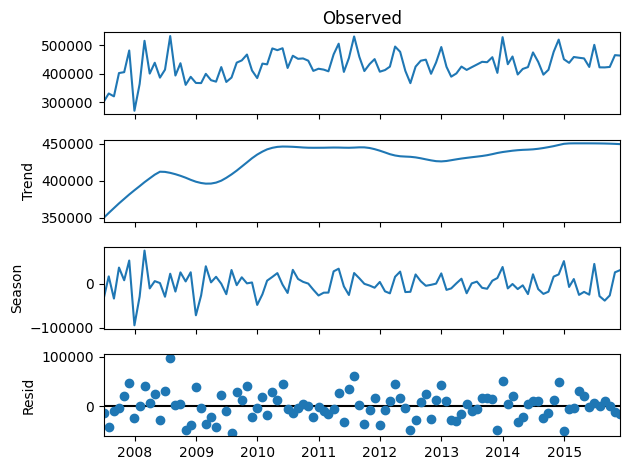

In [17]:
# decomposition
stl     = sm.tsa.STL(y_hist, 12)
results = stl.fit()    #  .fit() Runs the decomposition and gives you access to the components.

trend    = results.trend           # Trend = smoothed long-term movement.
seasonal = results.seasonal        # Seasonal = repeating pattern with period 12.
resid    = results.resid           # Resid = leftover random noise
results.plot()                       # Nicely visualizes the decomposition.


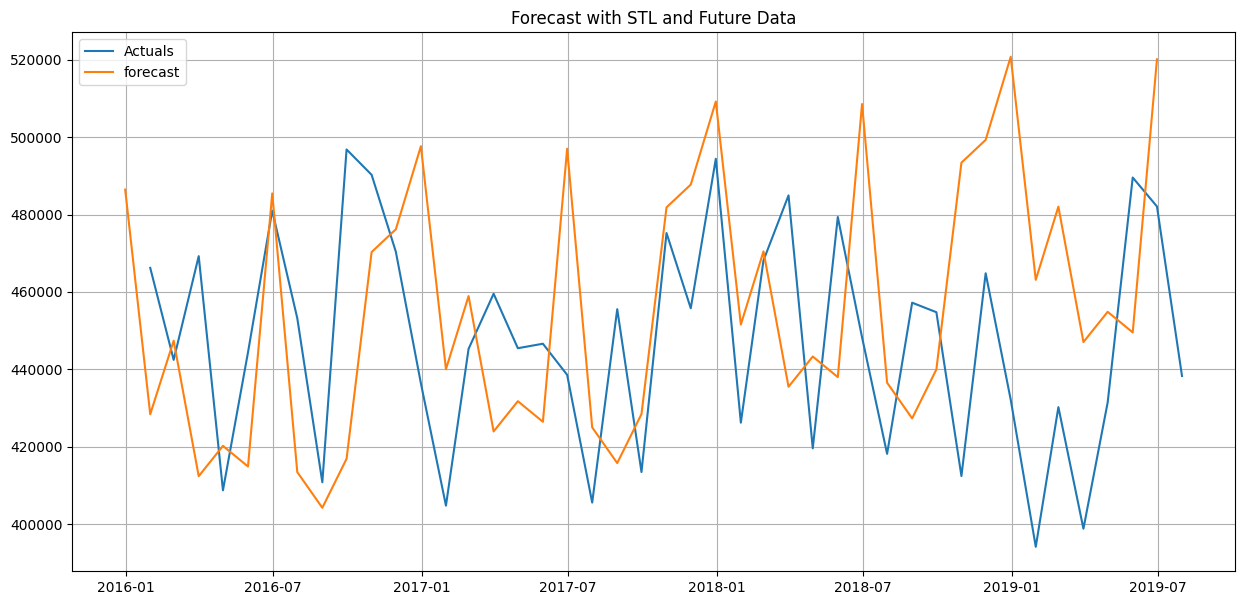

In [18]:

stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0), 'trend':"t"} )
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(y_future))

### Plot
plt.figure(figsize=(15,7))
#plt.plot(y_hist, label = 'Historic data')
plt.plot(y_future, label = 'Actuals')
plt.plot(forecast, label = 'forecast')

plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();
